In [1]:
import cudf
import cuspatial as csp

In [20]:
import os
yrs = [str(x) for x in (2019,2020,2021)]
file_names = []
for yr in yrs:
    file_names += [f"../../US_MARINE/{yr}/parquets/" + x for x in os.listdir(f"../../US_MARINE/{yr}/parquets/")]
cargo_file_names = sorted([x for x in file_names if "cargo" in x])
tanker_field_names = sorted([x for x in file_names if "tanker" in x])

In [58]:
%%time
vessel_names_list = []
imo_names_list = []
for f in cargo_file_names:
    tmp = cudf.read_parquet(f)
    vessels = tmp.VesselName.unique().to_arrow().tolist()
    imos = tmp.IMO.unique().to_arrow().tolist()
    vessel_names_list += vessels
cargo_vessel_names = set(vessel_names_list)

CPU times: user 23.1 s, sys: 2.59 s, total: 25.7 s
Wall time: 26.2 s


In [28]:
len(cargo_vessel_names)

9235

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Region    3 non-null      object  
 1   geometry  3 non-null      geometry
dtypes: geometry(1), object(1)
memory usage: 176.0+ bytes
None


<AxesSubplot:>

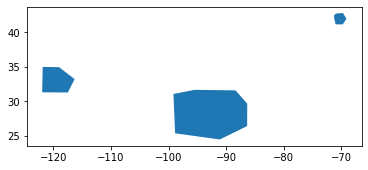

In [30]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
los_angeles = Polygon([[-121.88232421875,34.9895035675793],
            [-121.97021484374999,31.316101383495624],
            [-117.5042724609375, 31.287939892641734],
            [-116.32873535156249,33.224903086263964],
            [-119.02587890624999,34.95349314197422],
            [-121.88232421875,34.9895035675793]])
boston = Polygon([[-70.86456298828124,42.71473218539458],
            [-71.20513916015625,42.48627657532139],
            [-71.21063232421875,42.116561350389006],
            [-70.938720703125,41.14970617453726],
            [-69.70275878906249,41.15384235711447],
            [-69.0435791015625,41.96357478222518],
            [-69.6697998046875,42.79540065303723],
            [-70.86456298828124,42.71473218539458]])
gom = Polygon([[-99.140625, 31.071755902820133],
            [-98.85498046875, 25.383735254706867],
            [-91.07666015625, 24.487148563173424],
            [-86.33056640625, 26.43122806450644],
            [-86.30859375, 29.668962525992505],
            [-88.35205078124999,31.59725256170666],
            [-95.49316406249999, 31.672083485607402],
            [-99.140625,31.071755902820133]])
df = pd.DataFrame([["LA",los_angeles],['GOM',gom],['boston',boston]], columns=['Region','geometry'])
df = gpd.GeoDataFrame(df, geometry='geometry', crs=4326)
print(df.info())
df.plot()

In [43]:
minx, miny, maxx, maxy = df[df.Region == "GOM"].envelope.__geo_interface__['features'][0]['bbox']

In [47]:
csp.points_in_spatial_window(min_x=minx, max_x=maxx, min_y=miny, max_y=maxy, xs=tmp['LON'], ys=tmp['LAT'])

,x,y
0,-95.00027,29.61270
1,-95.00043,29.61265
2,-95.00043,29.61265
3,-95.00043,29.61263
4,-95.00040,29.61265
...,...,...
64966,-86.37760,24.70125
64967,-86.36566,24.69180
64968,-86.34540,24.68341
64969,-86.32387,24.67315


In [54]:
poly_points_x = [x[0] for x in df[df.Region == "GOM"].geometry.__geo_interface__['features'][0]['geometry']['coordinates'][0][:-1]]
poly_points_y = [x[1] for x in df[df.Region == "GOM"].geometry.__geo_interface__['features'][0]['geometry']['coordinates'][0][:-1]]

In [60]:
%%time
t = csp.point_in_polygon(tmp.LON, tmp.LAT, cudf.Series([0], index=['GOM']), [0],poly_points_x,poly_points_y)
t[t.GOM == True]

CPU times: user 6.35 ms, sys: 303 µs, total: 6.65 ms
Wall time: 5.97 ms


,GOM
3061,True
3062,True
3063,True
3064,True
3065,True
...,...
255659,True
255660,True
255661,True
255662,True


In [63]:
tmp.loc[t[t.GOM == True].index][['BaseDateTime','MMSI','LAT','LON','VesselName','IMO','SOG']]

,BaseDateTime,MMSI,LAT,LON,VesselName,IMO,SOG
3061,2021-12-31 00:00:00,538009216.0,29.61270,-95.00027,SEAMAX DARIEN,IMO9243394,0.1
3062,2021-12-31 00:05:00,538009216.0,29.61265,-95.00043,SEAMAX DARIEN,IMO9243394,0.1
3063,2021-12-31 00:10:00,538009216.0,29.61265,-95.00043,SEAMAX DARIEN,IMO9243394,0.1
3064,2021-12-31 00:15:00,538009216.0,29.61263,-95.00043,SEAMAX DARIEN,IMO9243394,0.1
3065,2021-12-31 00:20:00,538009216.0,29.61265,-95.00040,SEAMAX DARIEN,IMO9243394,0.1
...,...,...,...,...,...,...,...
255659,2021-12-31 23:35:00,477826600.0,27.46033,-88.52127,AMOY DREAM,IMO9583615,12.9
255660,2021-12-31 23:40:00,477826600.0,27.47457,-88.53260,AMOY DREAM,IMO9583615,13.0
255661,2021-12-31 23:45:00,477826600.0,27.48883,-88.54284,AMOY DREAM,IMO9583615,13.0
255662,2021-12-31 23:50:00,477826600.0,27.50371,-88.55237,AMOY DREAM,IMO9583615,13.0
